In [11]:
import warnings
import psutil
import random
import time

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="tkinter")


In [12]:
from models2.runMLnet import *
from models2.Input_prepare import *
from models2.calculateLRscore import *
from models2.utils import *

In [13]:
# setting global name and path
DATA_NAME = 'CCCvelo_demo'

ROOT_DIR = f"./{DATA_NAME}"
DATA_DIR = os.path.join(ROOT_DIR, "data", "processed")
RESULTS_DIR = os.path.join(ROOT_DIR, "results")

MLNET_DIR = os.path.join(RESULTS_DIR, "mlnet")
MODEL_DIR = os.path.join(RESULTS_DIR, "trained_model")
TG_PRED_DIR = os.path.join(RESULTS_DIR, "tg_prediction")
LOSS_DIR = os.path.join(RESULTS_DIR, "loss_curves")
VISUALIZE_DIR = os.path.join(RESULTS_DIR, "visualize")

# create folders
for dir_path in [DATA_DIR, MODEL_DIR, MLNET_DIR, TG_PRED_DIR, LOSS_DIR, VISUALIZE_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [14]:
hidden_dims=[150, 150, 150]
learning_rate=0.001
lambda_reg=0.01
batch_size=1500
n_epochs=5

In [15]:
input_dir = DATA_DIR

# load data
print("Loading data...")
data_files = {
    'count_file': 'raw_expression_mtx.csv',
    'imput_file': 'imputation_expression_mtx.csv',
    'meta_file': 'cell_meta.csv',
    'loca_file': 'cell_location.csv'
}
paths = {key: os.path.join(input_dir, fname) for key, fname in data_files.items()}
adata = ReadData(**paths)
print(adata)

Loading data...
AnnData object with n_obs × n_vars = 7765 × 15284
    obs: 'Cluster'
    obsm: 'spatial'
    layers: 'Imputate'


In [16]:
print("Loading database...")
TGs_list = load_json(os.path.join(input_dir, "TGs_list.json"))
Ligs_list = load_json(os.path.join(input_dir, "Ligs_list.json"))
Recs_list = load_json(os.path.join(input_dir, "Recs_list.json"))

Loading database...


In [17]:
# construct multilayer network 
rec_clusters = ['Isocortex L6', 'Isocortex L5', 'Isocortex L4', 'Isocortex L23']
print("Building multilayer network...")
resMLnet = runMLnet(
    adata=adata,
    LigClus=None,
    RecClus=rec_clusters,
    OutputDir=MLNET_DIR,
    Databases=None,
    RecTF_method="Search",
    TFTG_method="Search",
    TGList=TGs_list,
    LigList=Ligs_list,
    RecList=Recs_list
)

ex_mulnetlist = {
        name: mlnet
        for receiver, sender_dict in resMLnet["mlnets"].items()
        for name, mlnet in sender_dict.items()
        if not mlnet["LigRec"].empty
    }
    # print(ex_mulnetlist.items())
  
print("Multilayer network nodes summary:")
print(summarize_multilayer_network(ex_mulnetlist))
 

Building multilayer network...
Load default database
LigRecDB: shape = (3671, 2)
RecTFDB: shape = (17450, 2)
TFTGDB: shape = (373501, 2)
WorkDir: ./CCCvelo_demo\results\mlnet\runscMLnet
HIP & CTXpl L1_Isocortex L6
source_background: 53
target_background: 81
get 73 activated LR pairs
target_background: 15284
target_icg: 72
get 548 activated TFTG pairs
get 279 activated RecTF pairs
LR pairs: 59
TFTG pairs: 237
Isocortex L5_Isocortex L6
source_background: 62
target_background: 81
get 87 activated LR pairs
target_background: 15284
target_icg: 72
get 548 activated TFTG pairs
get 292 activated RecTF pairs
LR pairs: 70
TFTG pairs: 237
Isocortex L23_Isocortex L6
source_background: 64
target_background: 81
get 91 activated LR pairs
target_background: 15284
target_icg: 72
get 548 activated TFTG pairs
get 281 activated RecTF pairs
LR pairs: 71
TFTG pairs: 237
HY_Isocortex L6
source_background: 65
target_background: 81
get 90 activated LR pairs
target_background: 15284
target_icg: 72
get 548 activ

In [18]:
# 计算 LR-TF 分数
loop_calculate_LRTF_allscore(
    adata=adata,
    ex_mulnetlist=ex_mulnetlist,
    receiver_celltype=rec_clusters,
    diff_LigRecDB_path='E:/CCCvelo/data/Database/diff_LigRecDB.csv', 
    cont_LigRecDB_path='E:/CCCvelo/data/Database/cont_LigRecDB.csv', 
    OutputDir=MLNET_DIR
)

Saving model intermediate results to ./CCCvelo_demo\results\mlnet\runModel
the max dist is: 2925.884481656786
calculate the regulatory score of LR pairs from microenvironment to Isocortex L6
the max dist is: 2925.884481656786
calculate the regulatory score of LR pairs from microenvironment to Isocortex L5
the max dist is: 2925.884481656786
calculate the regulatory score of LR pairs from microenvironment to Isocortex L4
the max dist is: 2925.884481656786
calculate the regulatory score of LR pairs from microenvironment to Isocortex L23


'Done'

In [19]:
TFLR_all_score = get_TFLR_allactivity(
    mulNetList=ex_mulnetlist,
    OutputDir=MLNET_DIR
)

save_LRscore_and_MLnet(
    adata,
    mulNetList=ex_mulnetlist,
    TFLR_all_score=TFLR_all_score,
    save_path=MLNET_DIR
)  

Loading  LRTF_allscore_TME-Isocortex L23.pkl
Loading  LRTF_allscore_TME-Isocortex L4.pkl
Loading  LRTF_allscore_TME-Isocortex L5.pkl
Loading  LRTF_allscore_TME-Isocortex L6.pkl


In [20]:
# select receiver cells
print("Selecting receiver cells...")
celltype_ls = adata.obs['Cluster'].to_list()
ct_index_ls = []
for name in rec_clusters:
    ct_index_ls.extend(get_index1(celltype_ls, name))
adata = adata[ct_index_ls, :].copy()
x_coord = adata.obsm['spatial'][:, 0]
selected_cells = adata.obs.index[x_coord < 5500]
adata = adata[selected_cells].copy()
print(adata)

Selecting receiver cells...
AnnData object with n_obs × n_vars = 1976 × 15284
    obs: 'Cluster'
    obsm: 'spatial'
    layers: 'Imputate'
    obsp: 'DT_connectivities'


In [21]:
# prepare the input of CCCvelo
link_files = {
    'LR_link_file': 'LR_links.csv',
    'TFTG_link_file': 'TFTG_links.csv',
    'LRTF_score_file': 'TFLR_score/'
}
paths = {key: os.path.join(MLNET_DIR, fname) for key, fname in link_files.items()}
print('Loading link files from:', paths)

adata = PrepareInputData(adata, **paths)
adata.uns['Cluster_colors'] = ['#ff7f0e', '#2ca02c', '#1f77b4',  '#d62728']

torch.save(adata, os.path.join(MLNET_DIR, "pp_adata.pt"))

Loading link files from: {'LR_link_file': './CCCvelo_demo\\results\\mlnet\\LR_links.csv', 'TFTG_link_file': './CCCvelo_demo\\results\\mlnet\\TFTG_links.csv', 'LRTF_score_file': './CCCvelo_demo\\results\\mlnet\\TFLR_score/'}
the number of ligands is: 57
the number of receptors is: 55
the number of TFs is: 80
the number of TGs is: 138
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [22]:
adata = root_cell(adata, select_root='UMAP')
print('Root cell cluster is:', adata.obs['Cluster'][adata.uns['iroot']])

print("Training spatial velocity model...")
n_cells = adata.n_obs
print(f"Number of receiver cells: {n_cells}")
if n_cells <= 10000:
    print("Training with standard SpatialVelocity (full batch)...")
    
    from models2.train_CCCvelo import SpatialVelocity
    from models2.plot_CCCvelo import plot_gene_dynamic

    data = PrepareData(adata, hidden_dims=hidden_dims)
    model = SpatialVelocity(*data, lr=learning_rate, Lambda=lambda_reg)
    iteration_adam, loss_adam = model.train(200)

else:
    print("Training with batch SpatialVelocity (mini-batch mode)...")

    from models2.train_CCCvelo_batchs import SpatialVelocity
    from models2.plot_CCCvelo_batch import plot_gene_dynamic

    data = PrepareData(adata, hidden_dims=hidden_dims)
    model = SpatialVelocity(*data, lr=learning_rate, Lambda=lambda_reg, batch_size=batch_size)
    iteration_adam, loss_adam = model.train(n_epochs)
adata.write_h5ad(os.path.join(MODEL_DIR, 'adata_pyinput.h5ad'))

Root cell cluster is: Isocortex L6
Training spatial velocity model...
Number of receiver cells: 1976
Training with standard SpatialVelocity (full batch)...
the root cell is: 604
Training SpatialVelocity model...


e:\CCCvelo\TFvelo\settings.py:91: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=cbook.mplDeprecation)


loss1: 6.167e-01, loss2: 3.070e+00
It: 0, Loss: 6.474e-01
loss1: 5.217e-02, loss2: 1.017e+00
It: 100, Loss: 6.234e-02


In [ ]:
adata_copy = adata[:, adata.var['TGs'].astype(bool)]
adata_velo = get_raw_velo(adata_copy, model)

plot_gene_dynamic(adata_velo, model, VISUALIZE_DIR)

save_model_and_data(model, adata_velo, MODEL_DIR)
print("Pipeline finished successfully!")

Pipeline finished successfully!


        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


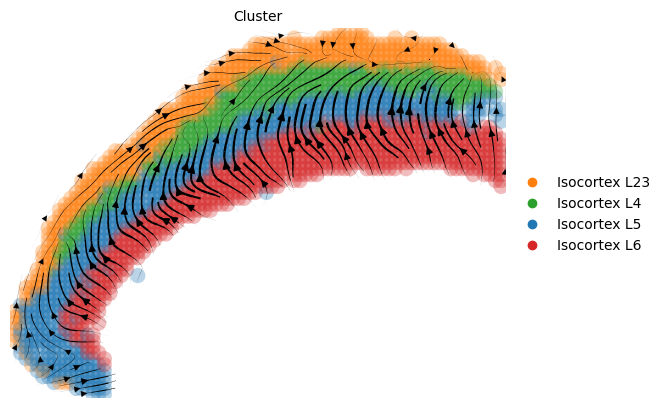

In [ ]:
adata_spa = adata_velo.copy()
scv.tl.velocity_graph(adata_spa, basis='spatial',vkey='velocity',xkey='Imputate')
scv.pl.velocity_embedding_stream(adata_spa,basis='spatial',vkey='velocity',smooth=0.5,cutoff_perc=0,color='Cluster',legend_loc='right margin')

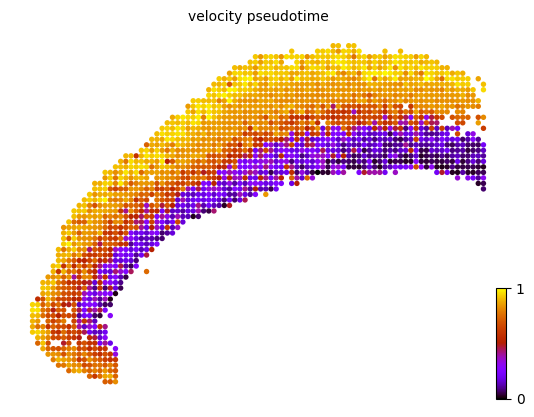

In [9]:
scv.tl.velocity_pseudotime(adata_spa)
scv.pl.scatter(adata_spa,basis='spatial',color='velocity_pseudotime',cmap='gnuplot')